In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from claw import *
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # lower dpi for faster plotting 
savefig = False # set false for faster plotting

In [3]:
random.seed(np.exp(1))
savefig = False

# Claw

Visualizing the worst case metric graph $G$, also called a *claw*, that is a complete bipartite graph

\begin{equation}
G = K_{1, 3}
\end{equation}

embedded in $\mathbb{R}^{2}$ in such a way it is hard to distinguish two edges because they are to close in the embedding space; see (Lecci et al., 2014):

[https://jmlr.csail.mit.edu/papers/volume15/lecci14a/lecci14a.pdf](https://jmlr.csail.mit.edu/papers/volume15/lecci14a/lecci14a.pdf)

Section 3.1.

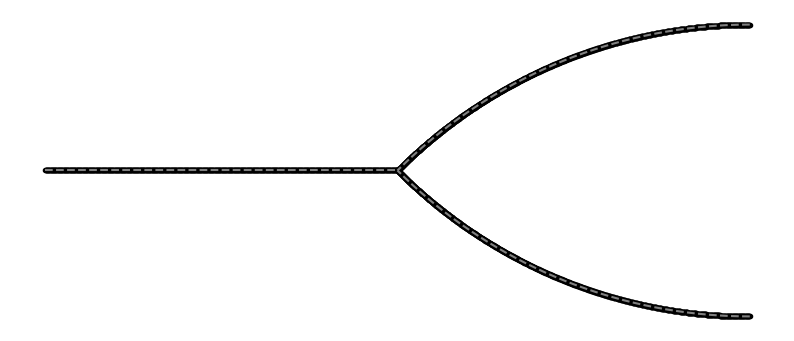

In [4]:
claw = Claw()
claw.plot_claw(savefig=savefig)

## Construction

We construct $G$ by gluing together 3 curves:

* line segment $a x$ of length 1;
* two arcs $e_{1} = x t_{1}$, $e_{2} = x t_{2}$ enclosing the angle $\theta$ from two circles with radius $\tau$ of lengths $\theta \tau$.

To represent $G$, we sample: 

* $n$ points from the interior of the line segment $a x$ 

* proportionally to the arcs lengths more points from interiour of each arc $e_{1}, e_{2}$:

$$
\lfloor \theta \tau n \rfloor
$$

* and add 3 boundary points and one point of intersection to the sample.

For 
\begin{align*}
\theta &= \frac{\pi}{4} \\
\tau &= \sqrt{2}
\end{align*}

the length of arcs are:

In [5]:
np.pi/4 * np.sqrt(2)

1.1107207345395915

And for $n = 10$ points in the line segment $a x$ represented in blue in the figure below, we have 

In [6]:
n = 10
int(np.floor(np.pi/4 * np.sqrt(2) * n))

11

points for each arc, represented in green and red. Boundary points and point of intersection are represented in black.

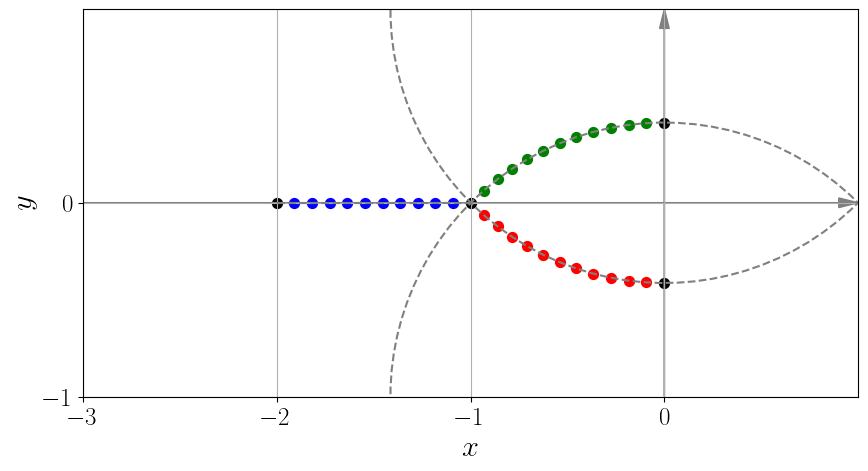

In [7]:
claw = Claw(n=10)
claw.plot_parts(plot_construction=True, savefig=savefig)

## Sampling

**Definition.** A sample $Y = \lbrace y_{k} \rbrace_{k=1}^{n} \subset G$ is $\frac{\delta}{2}$*-dense* in $G$ if for each $x \in G$ there exists $y \in Y$ such that 
$$
\left\lVert x - y \right\rVert_{2} < \frac{\delta}{2}
$$

In other words, if the union of open balls of radius $\frac{\delta}{2}$ around $y_{k}, k = 1, ..., n$, cover $G$.

For $\delta=0.2$. Sample of $n=10$ points that is not $\frac{\delta}{2}$-dense in $G$:

False


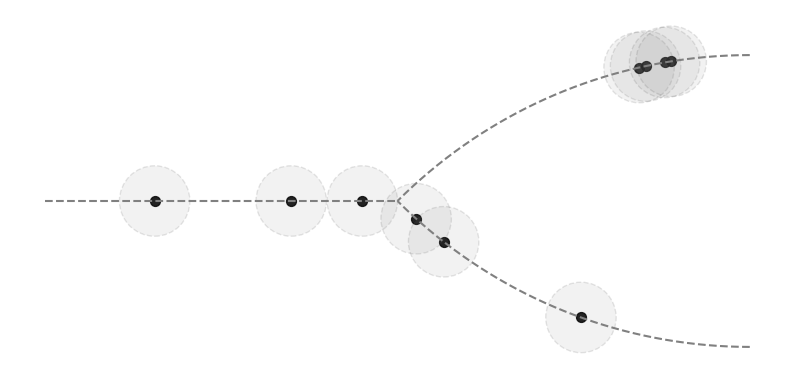

In [8]:
delta = 0.2

claw = Claw()
sample_points = claw.get_sample_points(10)
print(claw.is_dense(sample_points, delta))
claw.plot_sample(sample_points, delta, savefig=savefig)

Sample of $n=30$ points that is $\frac{\delta}{2}$-dense in $G$:

True


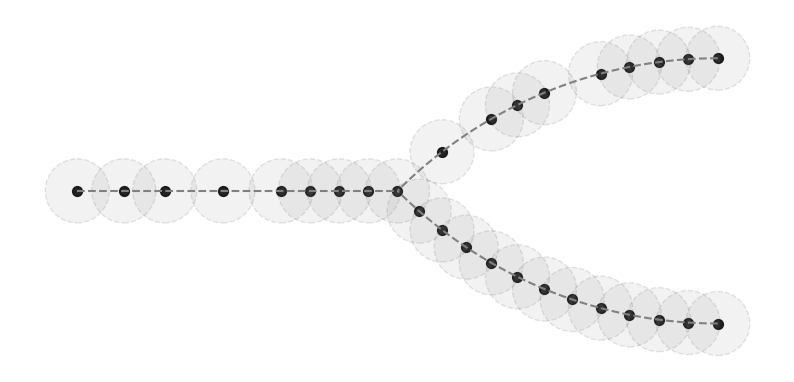

In [9]:
sample_points = claw.load_sample('claw_dense_sample_30_points')
print(claw.is_dense(sample_points, delta))
claw.plot_sample(sample_points, delta, savefig=savefig)

## Reconstruction

| Simbol  | Description  | Value  |
|:-:|:-:|:-:|
| ($G, d_{G}$) | metric graph  | worst case $K_{1, 3}$ embedding in $\mathbb{R}^{2}$  |
| $\alpha$  | smallest angle  | $\frac{\pi}{2}$  | 
| $b$  | shortest edge  | 1  |
| $\tau$  | local reach  | $\sqrt{2}$  |
| $\xi$  | global reach  | $\sqrt{2} (\sqrt{2} - 1)$  |

**Assumptions.** Assumptions that must be met for reconstruction:

* **A1.** $\text{length}(G) = 1 + \theta \tau = 1 + \frac{\pi}{4} \sqrt{2} < \infty$;

* **A2.** Edges of $G$ are embedded sub-manifolds of dimension 1 with minimum length $b = \min \lbrace 1, \theta \tau \rbrace = 1$ and minimum reach $\tau = \sqrt{2} > 0$;

* **A3.** And minimum angle $\alpha = \min \lbrace \frac{3 \pi}{4}, \frac{\pi}{2}\rbrace > 0$;

* **A4.** Global reach $\xi = \sqrt{2} (\sqrt{2} - 1) > 0$.

Where for $t_{1} = (0, \sqrt{2} - 1), t_{2} = (0, 1 - \sqrt{2})$

$$
\xi = \inf_{x, x' \in A_{G}} \left\lVert x - x' \right\rVert_{2} = d_{G}(t_{1}, t_{2})
$$

and

$$
A_{G} = \lbrace (x, x') \in G \times G : d_{G}(x, x') \geq \min (b, \tau \alpha) = 1 \rbrace = V_{G} \times V_{G}
$$

**Algorithm.**

Input: $Y, d_{Y}$ where $Y$ is $\frac{\delta}{2}$-dense sample from $G$. Values of parameters $\delta = 0.2, r = 0.1, p11 = 0.1$.

Output: A reconstruction $\hat{G}$ of $G$.

Steps:

* **Labeling.** Construct $\text{Rips}_{\delta}(S_{y})$ where $S_{y} = B(y, r + \delta) \setminus B(y, r)$ and label $y$ as edge point `E` in blue if $\text{deg}_{\text{Rips}_{\delta}}(y) = 2$. Otherwise label $y$ as vertex point `V` in red;

* **Expanding.** Relabel as vertex point `V` in red all points with distance to vertex points less than `p11`;

* **Reconstructing.** Let the connected components of $\text{Rips}_{\delta}(V)$ be vertices of reconstructed graph $\hat{G}$ represented by centers of mass of point clouds $V$. There is an edge between vertices of $\hat{G}$ if their corresponding connected components in $\text{Rips}_{\delta}(V)$ contain points at distance less than delta from the same component of $\text{Rips}_{\delta}(E)$.

Let's visualize the steps of the algorithm on the sample of $n=30$ points that is $\frac{\delta}{2}$-dense in $G$ with $r = 1, \delta = 0.2, p11 = 0.1$.

### Labeling

In [10]:
from metric_graph_reconstruction import *

In [11]:
sample_points = claw.load_sample('claw_dense_sample_30_points')
claw_points = []
for sample_point in sample_points:
    claw_points.append(Point(sample_point[0], sample_point[1]))
    
point_cloud = PointCloud(claw_points)    

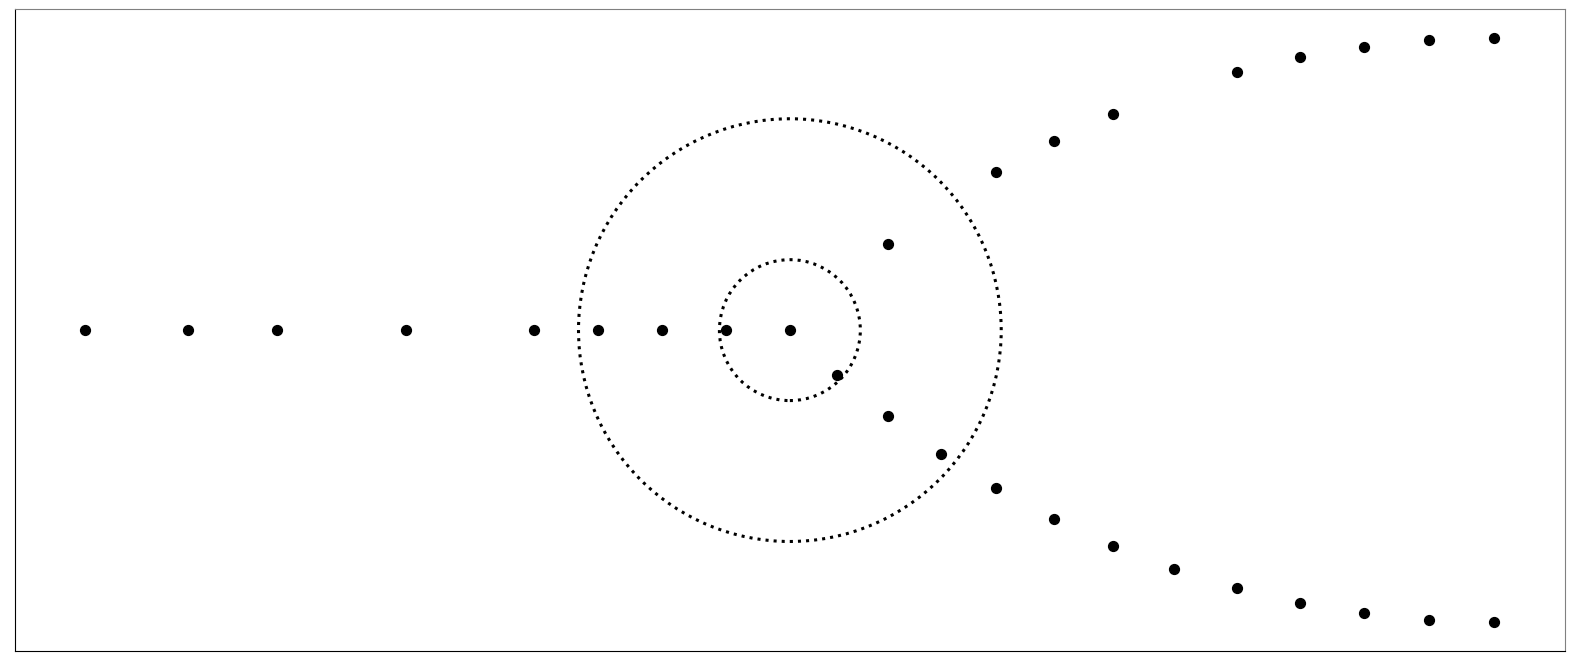

In [12]:
space = Space(2)

r = 0.1
delta = 0.2

space.draw_points(point_cloud.points)

center = point_cloud.points[15]
space.draw_shell(center, r)
space.draw_shell(center, r + delta)
space.show()

In [13]:
shell_points = get_shell_points(point_cloud.points, center, r, delta)

for point in point_cloud.points:
    if point in shell_points:
        print( 'P' + str(point_cloud.points.index(point) + 1) )

P7
P9
P11
P24
P25


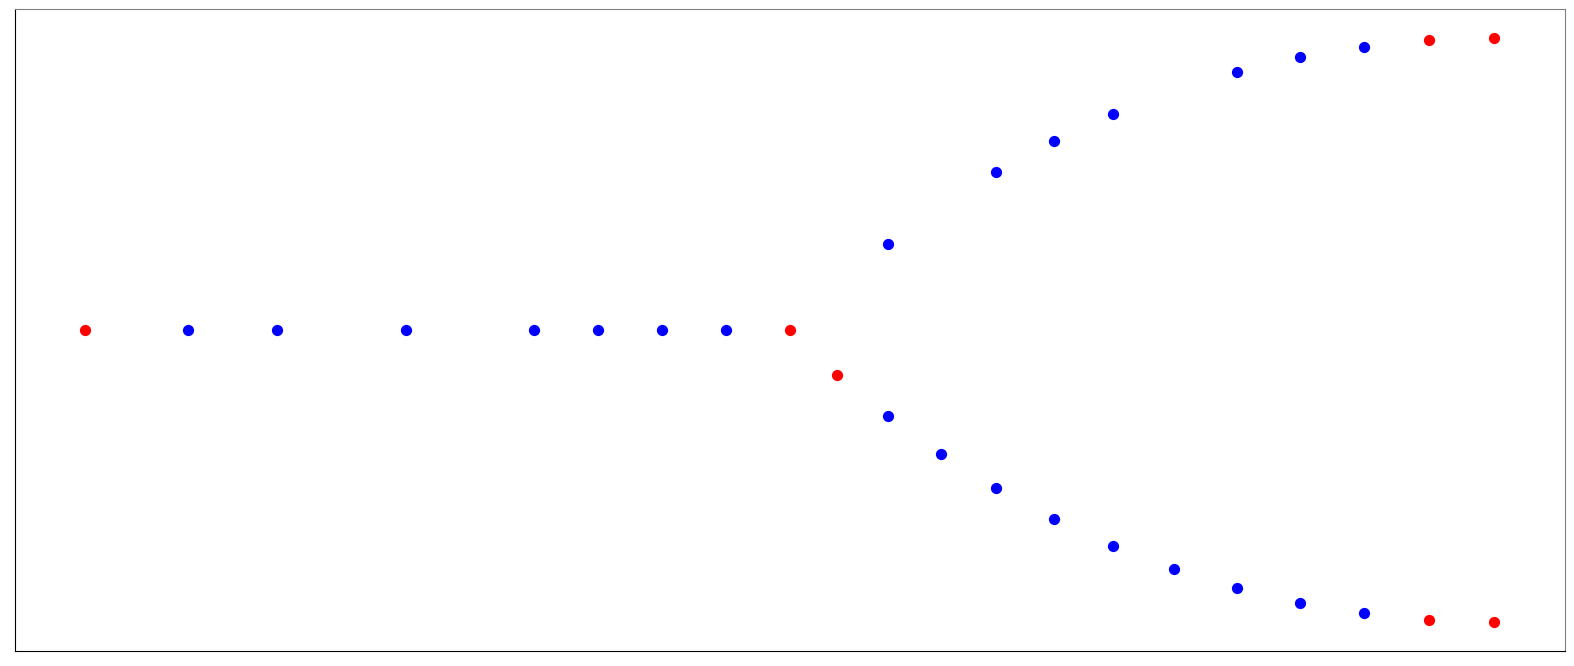

In [14]:
show = True
## label the points as edge or vertex points
for center in point_cloud.points:
    shell_points = get_shell_points(point_cloud.points, center, r, delta)
    rips_embedded = rips_vietoris_graph(delta, shell_points)

    if rips_embedded.k == 2:
        center.label = 'E'
    else:
        center.label = 'V'
if show:
    # after labeling step
    space = Space(2)
    space.draw_points(point_cloud.points)

In [15]:
for point in point_cloud.points:
    if point in point_cloud.vertex_points:
        print( 'P' + str(point_cloud.points.index(point) + 1) )

P3
P8
P10
P13
P16
P17
P27


### Expanding

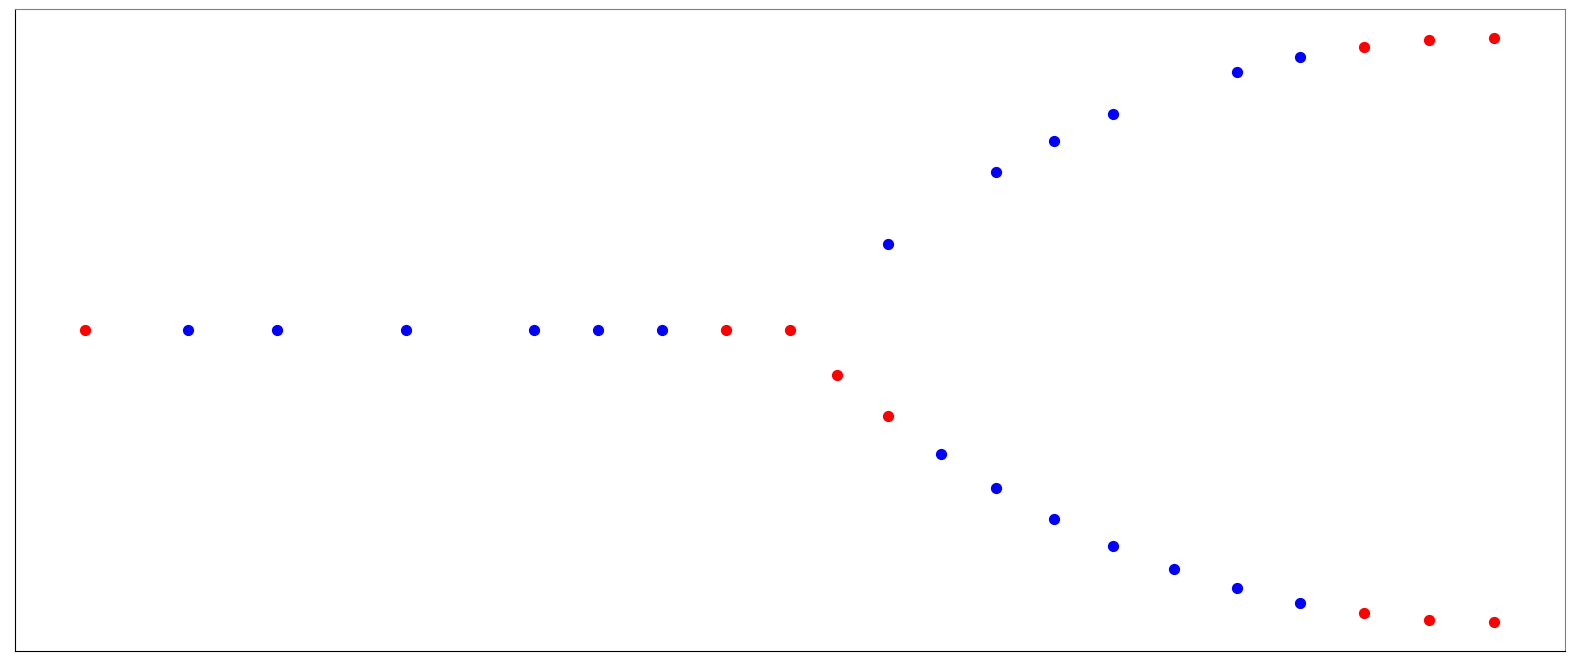

In [16]:
p11 = 0.1

# relabel all the points withing distance p11 from preliminary vertex
# points as vertices
for center in point_cloud.vertex_points:
    ball_points = get_ball_points(point_cloud.edge_points, center, p11)
    for ball_point in ball_points:
        ball_point.label = 'V'
if show:
    # after expansion step
    space = Space(2)
    space.draw_points(point_cloud.points)

In [17]:
for point in point_cloud.points:
    if point in point_cloud.vertex_points:
        print( 'P' + str(point_cloud.points.index(point) + 1) )

P2
P3
P8
P10
P13
P14
P16
P17
P25
P26
P27


### Reconstructing the graph structure

In [18]:
# compute the connected components of Rips-Vietoris graphs:
# R_delta(vertex_points), R_delta(edge_points)
rips_V = rips_vietoris_graph(delta, point_cloud.vertex_points)
rips_E = rips_vietoris_graph(delta, point_cloud.edge_points)

In [19]:
cmpts_V = rips_V.components
for cmpt_V, cmpt_points in cmpts_V.items():
    print('Component ' + str(cmpt_V + 1) + ':', end=' ')
    for cmpt_point in cmpt_points:
        print( 'P' + str(point_cloud.points.index(cmpt_point) + 1), end=', ')
    print()

Component 1: P2, P25, P10, P16, 
Component 2: P3, P13, P26, 
Component 3: P8, P27, P14, 
Component 4: P17, 


In [20]:
cmpts_E = rips_E.components
for cmpt_E, cmpt_points in cmpts_E.items():
    print('Component ' + str(cmpt_E + 1) + ':', end=' ')
    for cmpt_point in cmpt_points:
        print( 'P' + str(point_cloud.points.index(cmpt_point) + 1), end=', ')
    print()

Component 1: P1, P6, P9, P12, P23, P29, 
Component 2: P4, P7, P11, P15, P22, P28, 
Component 3: P5, P18, P19, P20, P21, P24, P30, 


In [21]:
for i, cmpt_points in cmpts_V.items():
    cmpts_V[i] = PointCloud(cmpt_points)

for j, cmpt_points in cmpts_E.items():
    cmpts_E[j] = PointCloud(cmpt_points)

In [22]:
nodes_emb_G = []
for i, cmpt_V in cmpts_V.items():
    nodes_emb_G.append(cmpt_V.center)

In [23]:
n = len(nodes_emb_G)
edges_emb_G = []
for i in range(n):
    for j in range(i + 1, n):
        for cmpt_E in cmpts_E.values():
            if cmpts_V[i].distance(cmpt_E) < delta and \
               cmpts_V[j].distance(cmpt_E) < delta:
                edges_emb_G.append([nodes_emb_G[i], nodes_emb_G[j]])

In [24]:
emb_G = EmbeddedGraph(nodes_emb_G, edges_emb_G)

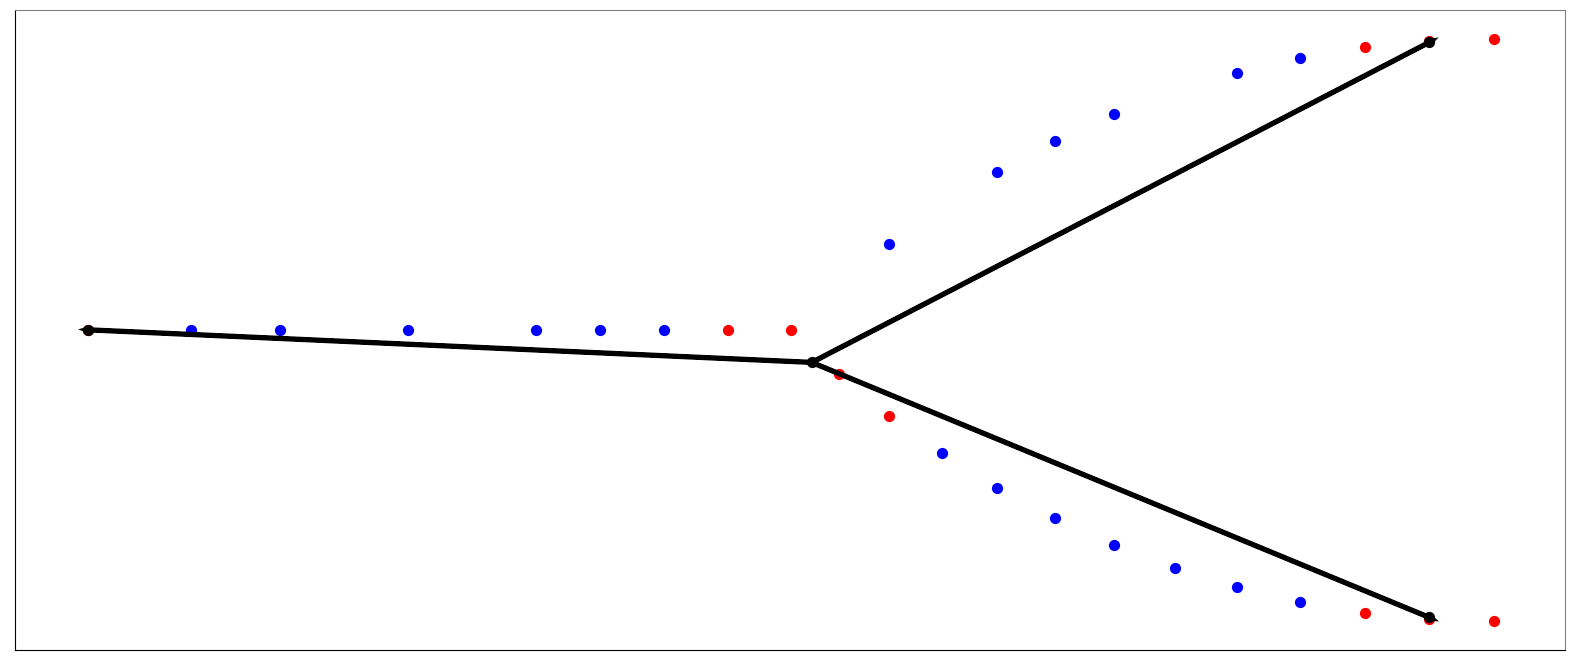

In [25]:
space = Space(2)
space.draw_points(point_cloud.points)
space.draw_graph(emb_G, color='black')

## Sampling with noise

We replace $G$ with $\sigma$-tube around $G$ defined as

$$
G_{\sigma} = \lbrace 
y : \inf_{x \in G} \left\lVert x - y \right\rVert_{2} \leq \sigma
\rbrace
$$

In other words, $G_{\sigma}$ is the union of all closed balls of radius $\sigma$ around points $x$ of $G$.

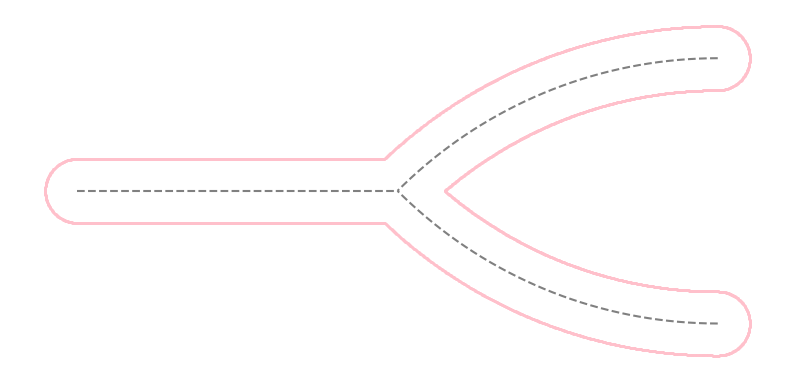

In [26]:
claw.plot_sigma_tube(0.1)

And demand that a sample $Y$ is $\frac{\delta}{2}$-dense in $G_{\sigma}$.

TODO: This is even stronger demand for $Y$, since the open balls around $y \in Y$ have to now cover the set $G_{\sigma}$ and $|G_{\sigma}| > |G|$.